In [1]:
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
california = fetch_california_housing()
X = pd.DataFrame(california.data.astype('float32'), columns=california.feature_names)
y = california.target

# Feature Importance

In [3]:
TEST_SIZE = 0.2
RANDOM_SEED = 2020
N_FOLD = 5

## without KFold

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    importance_type="gain", # TODO: check 'weight' and 'cover'
    random_state=RANDOM_SEED,
)
evals_result = {}
model.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=5,
    verbose=10,
    eval_metric='rmse',
    callbacks=[xgb.callback.record_evaluation(evals_result)],
)

pred = model.predict(X_test)

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.
Will train until validation_1-rmse hasn't improved in 5 rounds.
[0]	validation_0-rmse:1.43900	validation_1-rmse:1.44776
[10]	validation_0-rmse:0.47500	validation_1-rmse:0.52740
[20]	validation_0-rmse:0.41523	validation_1-rmse:0.49083


/Users/ryotaro.shimizu/.pyenv/versions/3.7.9/lib/python3.7/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[30]	validation_0-rmse:0.37941	validation_1-rmse:0.47939
[40]	validation_0-rmse:0.35717	validation_1-rmse:0.47417
Stopping. Best iteration:
[38]	validation_0-rmse:0.35895	validation_1-rmse:0.47411


In [5]:
print(f"RMSE: {mean_squared_error(y_test, pred, squared=False)}")
print(f"R^2: {r2_score(y_test, pred)}")

RMSE: 0.4741107130369501
R^2: 0.8340943552033905


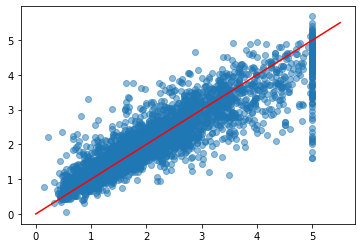

In [6]:
plt.scatter(y_test, pred, alpha=0.5)
x_line = np.linspace(0, 5.5, 100)
plt.plot(x_line, x_line, color="red")
plt.show()

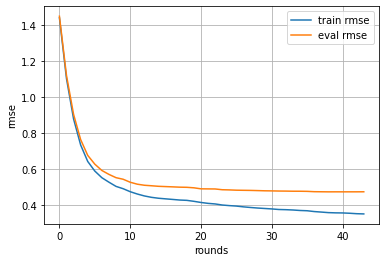

In [7]:
plt.plot(evals_result['validation_0']['rmse'], label='train rmse')
plt.plot(evals_result['validation_1']['rmse'], label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

- weight : その変数が全ての木の中にいくつ分岐点として存在するか
- gain : その変数が平均的にどれぐらい評価基準を改善しているのか(全分岐点についての平均)
- cover : (回帰問題では) ある入力に対して平均的に何度分岐に用いられているか(全入力についての平均)
- total_gain: WIP
- total_cover: WIP

importance_type (Optional[str])
- The feature importance type for the feature_importances_ property:
    - For tree model, it’s either “gain”, “weight”, “cover”, “total_gain” or “total_cover”.
    - For linear model, only “weight” is defined and it’s the normalized coefficients without bias.

see also:
- https://xgboost.readthedocs.io/en/latest/python/python_api.html
- https://qiita.com/hand10ryo/items/ed1e511b5236f7bfe606

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

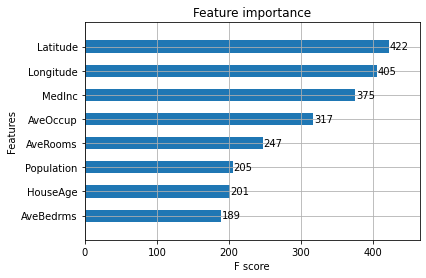

In [8]:
xgb.plot_importance(
    model,
    height=0.5,
    importance_type='weight',
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

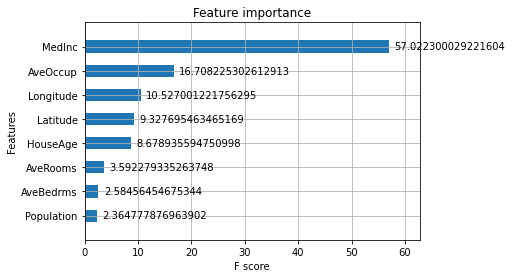

In [9]:
xgb.plot_importance(
    model,
    height=0.5,
    importance_type='gain',
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

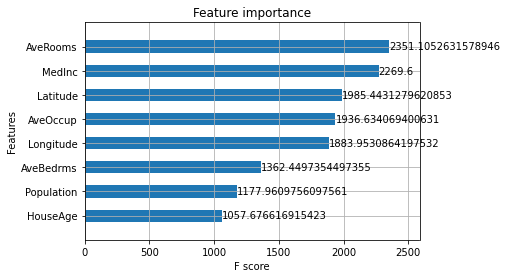

In [10]:
xgb.plot_importance(
    model,
    height=0.5,
    importance_type='cover',
)

In [11]:
# the orders are quite different

## with KFold

weight
[0]	validation_0-rmse:1.43900	validation_1-rmse:1.44776
[42]	validation_0-rmse:0.35296	validation_1-rmse:0.47425
[0]	validation_0-rmse:1.44451	validation_1-rmse:1.45116
[99]	validation_0-rmse:0.27905	validation_1-rmse:0.27680
[0]	validation_0-rmse:1.44931	validation_1-rmse:1.45002
[99]	validation_0-rmse:0.27897	validation_1-rmse:0.27619
[0]	validation_0-rmse:1.43913	validation_1-rmse:1.45013
[99]	validation_0-rmse:0.27344	validation_1-rmse:0.27067
[0]	validation_0-rmse:1.44947	validation_1-rmse:1.45055
[99]	validation_0-rmse:0.28035	validation_1-rmse:0.28010
gain
[0]	validation_0-rmse:1.43900	validation_1-rmse:1.44776
[43]	validation_0-rmse:0.35176	validation_1-rmse:0.47452
[0]	validation_0-rmse:1.44451	validation_1-rmse:1.45116
[99]	validation_0-rmse:0.27905	validation_1-rmse:0.27680
[0]	validation_0-rmse:1.44931	validation_1-rmse:1.45002
[99]	validation_0-rmse:0.27897	validation_1-rmse:0.27619
[0]	validation_0-rmse:1.43913	validation_1-rmse:1.45013
[99]	validation_0-rmse:0.273

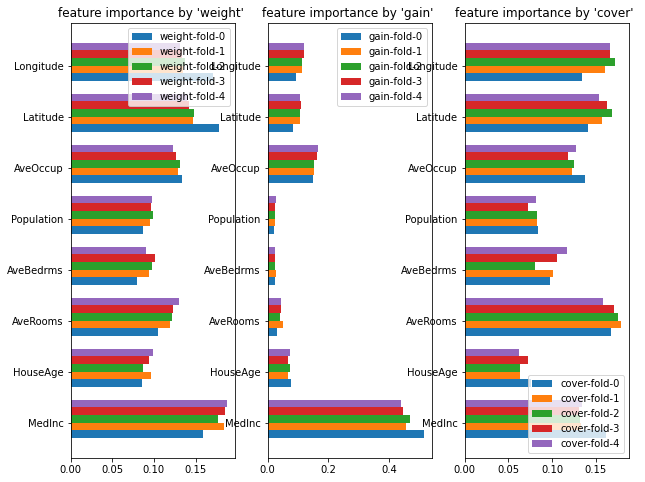

In [12]:
folds = KFold(n_splits=N_FOLD, shuffle=True, random_state=RANDOM_SEED)
height = 0.15
labels = X.columns
_, axs = plt.subplots(ncols=3, figsize=(10, 8))

for ax, method in zip(axs.ravel(), ["weight", "gain", "cover"]):
    print(method)
    fold_iter = folds.split(X, y=y)
    left = np.arange(len(labels), dtype=float) - (height*N_FOLD/2)
    
    for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
        X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_valid = y[trn_idx], y[val_idx]

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            importance_type=method, # TODO: check weight
            random_state=RANDOM_SEED,
        )
        model.fit(
            X=X_train,
            y=y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=5,
            verbose=100,
            eval_metric='rmse',
        )

        importances = list(model.feature_importances_)
        bar = ax.barh(left, importances, height=height, align='center', label=f"{method}-fold-{n_fold}")
        ax.bar_label(bar, label_type='center', fmt='')
        ax.legend()
        ax.set_title(f"feature importance by '{method}' ")
        ax.set_yticks(left-(height*N_FOLD)/2)
        ax.set_yticklabels(labels)

        left += height

plt.show()